In [261]:
#import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import patsy
import itertools
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression

# Question 8

In [38]:
# part a
np.random.seed(1)
x = np.random.normal(0, 1, 100)
#generating a noise vector as well
eps = np.random.normal(0,1,100)
#print(x)
#print(eps)

In [48]:
# part b
y = 2 + 2 * x + 3 * (x ** 2) + 2.5 * (x ** 3) + eps

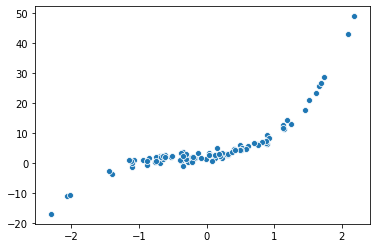

In [40]:
#let us now have a look at the plot
sns.scatterplot(x,y)

In [70]:
# it is now time to perform best-set sub selection
def bestSubsetSelection(k, z, y):
    # lets get a look at all the possible combinations
    print(type(z))
    x_combo = itertools.combinations(list(z.columns), k)
    
    #let us store the rss in an array
    models = []
    for combo in x_combo:
        x_smf = "+".join(combo)
        formula = "{} ~ {}".format(y.columns[0], x_smf)
        model = smf.ols(formula = formula, data = pd.concat([z,y], axis = 1)).fit()
        models.append((formula, model))
    return models

def min_rss(statsmodels):
    return sorted(statsmodels, key = lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    return sorted(statsmodels, reverse = True, key = lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    return sorted(statsmodels, reverse = False, key = lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    return sorted(statsmodels, reverse = False, key = lambda tup: tup[1].aic)[0]

In [58]:
# let us now create the data-frame
xt = pd.DataFrame({
    "X" : x,
    "X2": x ** 2,
    "X3": x ** 3,
    "X4": x ** 4,
    "X5": x ** 5,
    "X6": x ** 6,
    "X7": x ** 7,
    "X8": x ** 8,
    "X9": x ** 9,
    "X10": x ** 10})

yt = pd.DataFrame({"y" : y})
models = []
for k in range(len(xt.columns)):
    k = k + 1
    subset = bestSubsetSelection(k, xt, yt)
    models.append(subset)
    print(k, " done")

<class 'pandas.core.frame.DataFrame'>
1  done
<class 'pandas.core.frame.DataFrame'>
2  done
<class 'pandas.core.frame.DataFrame'>
3  done
<class 'pandas.core.frame.DataFrame'>
4  done
<class 'pandas.core.frame.DataFrame'>
5  done
<class 'pandas.core.frame.DataFrame'>
6  done
<class 'pandas.core.frame.DataFrame'>
7  done
<class 'pandas.core.frame.DataFrame'>
8  done
<class 'pandas.core.frame.DataFrame'>
9  done
<class 'pandas.core.frame.DataFrame'>
10  done


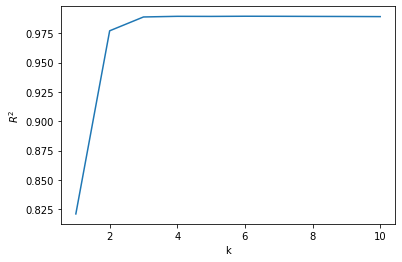

 Model Selected: 
  Intercept    2.298519
X            2.659149
X2           2.617578
X5           2.279830
X7          -0.684882
X9           0.065720
X10          0.001195
dtype: float64 0.9894773214922351


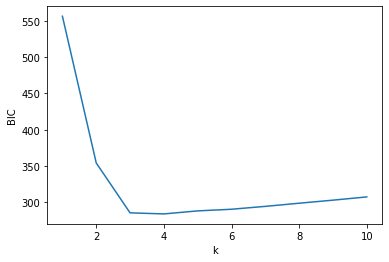

 Model Selected: 
 Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64 284.249197722063


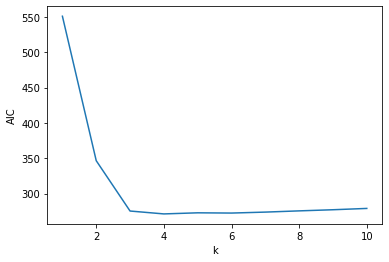

 Model Selected: 
  Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64 271.2233467921225


In [71]:
#time to see the results
k = np.arange(1, len(xt.columns) + 1)


#adjusted r squared
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in models]
sns.lineplot(x = k, y = adjr2)
plt.xlabel("k")
plt.ylabel("$R^2$")
plt.show()
coefs_r2 = [(max_adjr2(m)[1].rsquared_adj, max_adjr2(m)[1].params) for m in models]
print(" Model Selected: \n ", max(coefs_r2)[1], max(coefs_r2)[0])


#BIC
bic = [min_bic(m)[1].bic for m in models]
sns.lineplot(x = k, y = bic)
plt.xlabel("k")
plt.ylabel("BIC")
plt.show()
coefs_bic = [(min_bic(m)[1].bic, min_bic(m)[1].params) for m in models]
print(" Model Selected: \n", min(coefs_bic)[1], min(coefs_bic)[0])

#AIC
aic = [min_aic(m)[1].aic for m in models]
sns.lineplot(x = k, y = aic)
plt.xlabel("k")
plt.ylabel("AIC")
plt.show()
coefs_aic = [(min_aic(m)[1].aic, min_aic(m)[1].params) for m in models]
print(" Model Selected: \n ", min(coefs_aic)[1], min(coefs_aic)[0])

In [103]:
# Now we will do the same thing for forward stepwise selection and backward stepwise selection
def forwardStepwise(z, y, scorer = "ssr", results = [(0, [])]):
    p_all = list(z.columns)
    p_used = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    #base case
    if not p_unused:
        scores = [r[0] for r in results]
        predictors = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, "predictors" : predictors}).drop(0)
    
    # get the score for each additional predictor
    res = []
    for p in p_unused:
        f = "{} ~ {}".format(y.columns[0], " + ".join([p] + p_used))
        model = smf.ols(formula = f, data = pd.concat([z,y], axis = 1)).fit()
        res.append((model, [p] + p_used))
    
    # choose the predictor which produces the best results
    if scorer == "ssr":
        best_model = sorted(res, key = lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == "rsquared_adj":
        best_model = sorted(res, reverse = True, key = lambda tup: tup[0].rsquared_adj)[0]
        best_score = (best_model[0].rsquared_adj, best_model[1])
    elif scorer == "bic":
        best_model = sorted(res, key = lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1])
    elif scorer == "aic":
        best_model = sorted(res, key = lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1])
    new_results = results + [best_score]
    return forwardStepwise(z, y, scorer, new_results)


In [102]:
def backwardStepwise(x, y, scorer = "ssr", results = []):
    p_all = list(x.columns)
    if not results:
        f = "{} ~ {}".format(y.columns[0], "+".join(p_all))
        model = smf.ols(formula = f, data = pd.concat([x,y], axis = 1)).fit()
        if scorer == "ssr":
            return backwardStepwise(x,y,scorer,[(model.ssr, p_all)])
        elif scorer == "rsquared_adj":
            return backwardStepwise(x,y,scorer,[(model.rsquared_adj, p_all)])
        elif scorer == "bic":
            return backwardStepwise(x,y,scorer,[(model.bic, p_all)])
        elif scorer == "aic":
            return backwardStepwise(x,y,scorer,[(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds =  [r[1] for r in results]
        return pd.DataFrame({scorer: scores, "predictors": preds})
    
    res = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f = "{} ~ {}".format(y.columns[0], "+".join(p_test))
        model = smf.ols(formula = f, data = pd.concat([x,y], axis = 1)).fit()
        res.append((model, p_test))
    if scorer == "ssr":
        best_model = sorted(res, key = lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == "rsquared_adj":
        best_model = sorted(res, key = lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])
    elif scorer == "bic":
        best_model = sorted(res, key = lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1])
    elif scorer == "aic":
        best_model = sorted(res, key = lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1])
    new_results = results + [best_score]
    return backwardStepwise(x, y, scorer, new_results)

In [99]:
def subsetAnalysis(df, scorer):
    df["predictors_str"] = df["predictors"].astype(str)
    ax = sns.lineplot(x = "predictors_str", y = scorer, data = df, sort = False)
    plt.xticks(rotation = 90)
    plt.show()
    
    if scorer == "rsquared_adj":
        print(df[df[scorer] == df[scorer].max()].drop("predictors_str", axis = 1))
    else:
        print(df[df[scorer] == df[scorer].min()].drop("predictors_str", axis = 1))

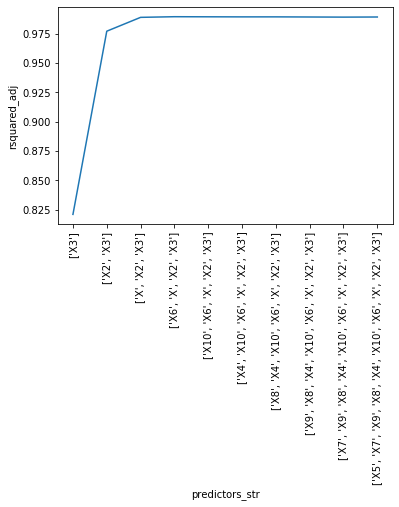

   rsquared_adj       predictors
4      0.989408  [X6, X, X2, X3]


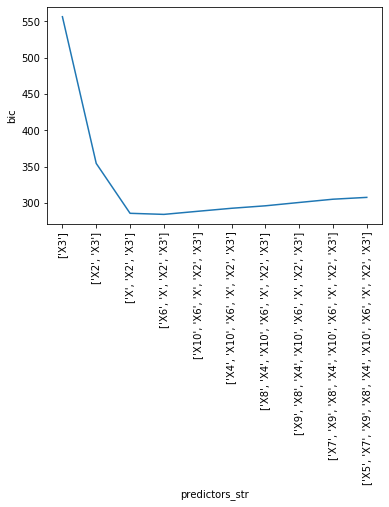

          bic       predictors
4  284.249198  [X6, X, X2, X3]


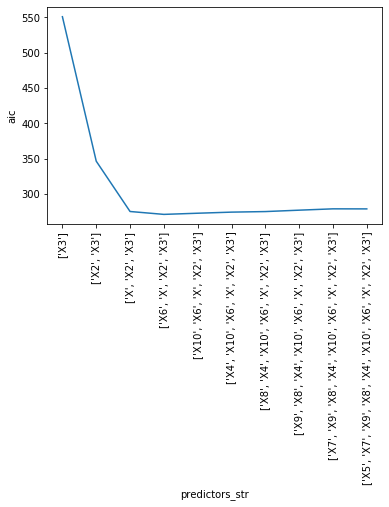

          aic       predictors
4  271.223347  [X6, X, X2, X3]


In [104]:
# rsquared
scorer = "rsquared_adj"
subsetAnalysis(forwardStepwise(xt,yt, scorer = scorer), scorer)
# rsquared
scorer = "bic"
subsetAnalysis(forwardStepwise(xt,yt, scorer = scorer), scorer)
# rsquared
scorer = "aic"
subsetAnalysis(forwardStepwise(xt,yt, scorer = scorer), scorer)

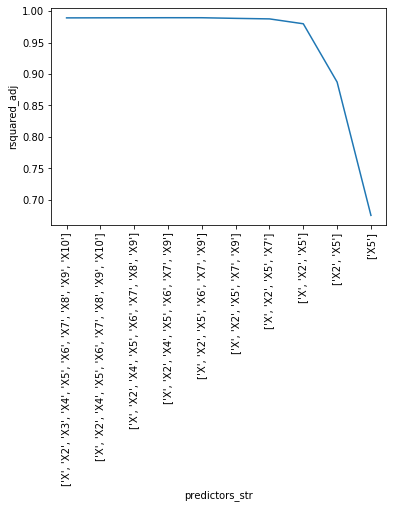

   rsquared_adj                   predictors
3      0.989431  [X, X2, X4, X5, X6, X7, X9]


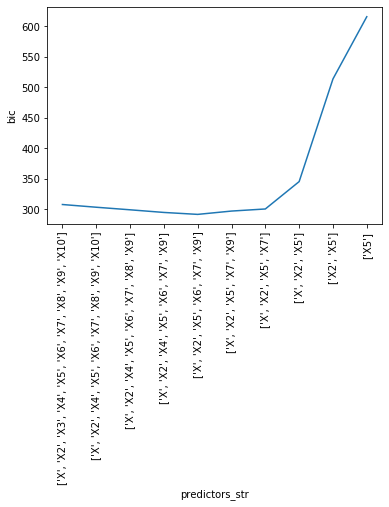

          bic               predictors
4  291.450514  [X, X2, X5, X6, X7, X9]


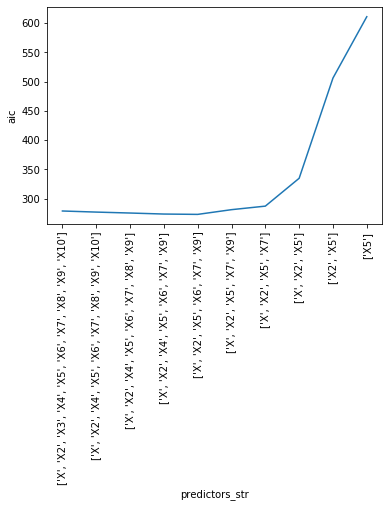

          aic               predictors
4  273.214322  [X, X2, X5, X6, X7, X9]


In [105]:
# time for some backward selection
#rsquared
scorer = "rsquared_adj"
subsetAnalysis(backwardStepwise(xt,yt, scorer = scorer), scorer)
# rsquared
scorer = "bic"
subsetAnalysis(backwardStepwise(xt,yt, scorer = scorer), scorer)
# rsquared
scorer = "aic"
subsetAnalysis(backwardStepwise(xt,yt, scorer = scorer), scorer)

In [106]:
# part e
# time to implement the lasso function
def mse(y_hat, y):
    return np.sum(np.square(y_hat - y)) / y.size

def lasso_cv(x, y, l, k):
    x_folds = np.array_split(x, k)
    y_folds = np.array_split(y, k)
    MSE = []
    for f in np.arange(len(x_folds)):
        x_test = x_folds[f]
        y_test = y_folds[f]
        x_train = x.drop(x_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        #time to fit the model
        model = linear_model.Lasso(alpha = l, fit_intercept = True, normalize = False,
                                   max_iter = 1000000).fit(x_train, y_train)
        y_hat = model.predict(x_test)
        MSE.append(mse(y_hat, y_test['y']))
    return MSE

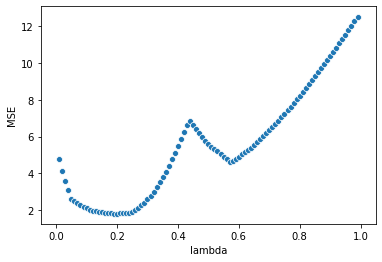

In [110]:
lambdas = np.arange(0.01, 1, 0.01)
MSE = []
for l in lambdas:
    MSE.append(np.mean(lasso_cv(xt, yt, l, 10)))

sns.scatterplot(x = "lambda", y = "MSE", data = pd.DataFrame({"lambda": lambdas, "MSE": MSE}))

In [113]:
min(zip(MSE, lambdas))

(1.8145436278960585, 0.19)

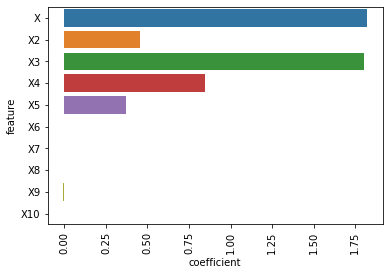

  feature  coefficient
0       X     1.823572
1      X2     0.454881
2      X3     1.802128
3      X4     0.847043
4      X5     0.373082
5      X6     0.000000
6      X7     0.000000
7      X8    -0.000000
8      X9    -0.009186
9     X10    -0.002988


In [122]:
lamb = min(zip(MSE, lambdas))[1]

model = linear_model.Lasso(alpha = lamb, fit_intercept = True, normalize = False, 
                           max_iter = 1000000).fit(xt, yt)
df = pd.DataFrame({"feature": xt.columns, "coefficient": model.coef_})

ax = sns.barplot(x = "coefficient", y ="feature", data = df)
plt.xticks(rotation = 90)
plt.show()
print(df)

# Question 9

In [214]:
college = pd.read_csv("college.csv")
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [215]:

college = college.drop("Unnamed: 0", axis = 1)
#college.rename_axis([None, "College"], inplace = True)
college = college.drop("Room.Board", axis = 1)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,800,1500,76,72,11.9,2,10922,15


In [216]:
# let us see if there are any null values
college.isnull().sum()

Private        0
Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

In [217]:
#there are no null values present in the data-set. It is time to convert the categorical columns
college = pd.get_dummies(college).drop("Private_No", axis = 1)
#convert everything into floats
college = college.astype(float)
#lets remove full stops from the column names
college = college.rename( index = str, columns = {
    "F.Undergrad" : "F_Undergrad",
    "P.Undergrad" : "P_Undergrad",
    "S.F.Ratio" : "S_F_Ratio",
    "perc.alumni" : "perc_alumni",
    "Grad.Rate" : "Grad_Rate"
    #"Room.Board" : " RoomBoard"
})
#college = college.drop("RoomBoard", axis = 1)
college.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
0,1660.0,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0,1.0
1,2186.0,1924.0,512.0,16.0,29.0,2683.0,1227.0,12280.0,750.0,1500.0,29.0,30.0,12.2,16.0,10527.0,56.0,1.0
2,1428.0,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0,1.0
3,417.0,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0,1.0
4,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0,1.0


In [218]:
# split the data into train and test data
from sklearn.model_selection import train_test_split
response = "Apps"
x = college.drop(response, axis = 1)
y = college[response]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

'''np.random.seed(1)
train = np.random.rand(len(college)) < 0.5
response = "Apps"
x_train = college[train].drop(response, axis = 1)
x_test = college[~train].drop(response, axis = 1)
y_train = college[train][response]
y_test = college[~train][response]'''
x_train.head()

,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
83,2193.0,753.0,16.0,34.0,2978.0,434.0,10750.0,400.0,1130.0,90.0,92.0,14.6,26.0,7972.0,64.0,1.0
61,7333.0,3076.0,14.0,45.0,13699.0,1213.0,7452.0,600.0,1700.0,81.0,89.0,21.1,14.0,6918.0,67.0,0.0
275,423.0,366.0,20.0,48.0,2448.0,707.0,9210.0,700.0,1000.0,49.0,51.0,39.8,15.0,6562.0,34.0,1.0
426,324.0,107.0,15.0,37.0,500.0,311.0,9990.0,400.0,600.0,44.0,47.0,12.1,26.0,4948.0,33.0,1.0
182,440.0,227.0,19.0,48.0,903.0,59.0,9650.0,600.0,1300.0,46.0,65.0,11.4,29.0,10188.0,82.0,1.0


In [219]:
# part b
f = "Apps ~ {}".format(" + ".join(x_train.columns))
model = smf.ols( f, pd.concat([x_train, y_train], axis = 1)).fit()
y_hat = model.predict(x_test)
print("RMSE", np.sqrt(mse(y_hat, y_test)))

RMSE 1340.2003858213411


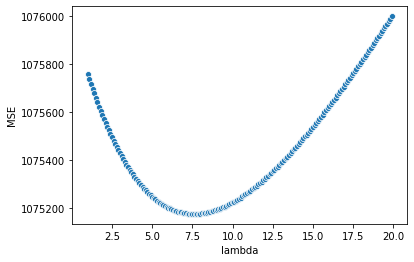

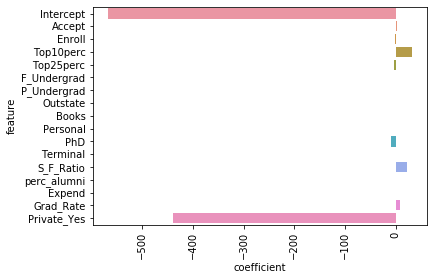

        feature  coefficient
0     Intercept  -567.445931
1        Accept     1.757647
2        Enroll    -1.310412
3     Top10perc    32.330508
4     Top25perc    -3.773980
5   F_Undergrad     0.034916
6   P_Undergrad     0.036554
7      Outstate    -0.062909
8         Books     0.249975
9      Personal     0.061054
10          PhD    -9.347227
11     Terminal     0.842779
12    S_F_Ratio    21.657233
13  perc_alumni     0.001879
14       Expend     0.066640
15    Grad_Rate     8.734721
16  Private_Yes  -438.631452
Optimal Lambda:  7.600000000000006


In [226]:
#time for ridge regression
def ridge_cv(x,y,l,k):
    x_folds = np.array_split(x, k)
    y_folds = np.array_split(y, k)
    MSE = []
    for f in np.arange(len(x_folds)):
        x_test = x_folds[f]
        y_test = y_folds[f]
        x_train = x.drop(x_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        model = linear_model.Ridge(alpha = l, fit_intercept = True, normalize = False, 
                                   solver = "cholesky").fit(x_train, y_train)
        y_hat = model.predict(x_test)
        MSE.append(mse(y_hat, y_test))
    return MSE

def optimise(x, y, cv, lambdas):
    MSE = []
    for l in lambdas:
        MSE.append(np.mean(cv(x,y,l,10)))
    sns.scatterplot(x = "lambda", y = "MSE", data = pd.DataFrame({"lambda": lambdas, "MSE":MSE}))
    plt.show()
    
    lamb = min(zip(MSE, lambdas))
    model = linear_model.Ridge(alpha = lamb[1], fit_intercept = True, normalize = False,
                              solver = "cholesky").fit(x,y)
    df = pd.DataFrame({"feature": "Intercept", "coefficient" : [model.intercept_]})
    ridge_df = df.append(pd.DataFrame({"feature": x.columns, "coefficient" : model.coef_}), 
                         ignore_index = True)
    ax = sns.barplot(x = "coefficient", y = "feature", data = ridge_df)
    plt.xticks(rotation = 90)
    plt.show()
    print(ridge_df)
    return lamb[1]
opt_lamb = optimise(x_train, y_train, ridge_cv, np.arange(1, 20, 0.1))
print("Optimal Lambda: ", opt_lamb)

In [228]:
#time to test the error
model = linear_model.Ridge(alpha = opt_lamb, fit_intercept = True, normalize = False,
                          solver = "cholesky").fit(x_train, y_train)
y_hat = model.predict(x_test)
print(np.sqrt(mse(y_hat, y_test)))

1338.6129252916091


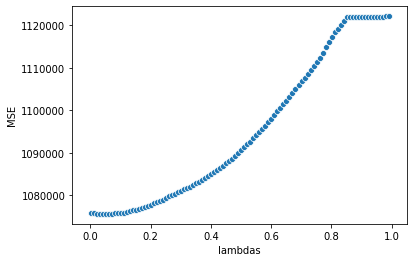

(1075647.7139970823, 0.040999999999999995)


In [230]:
#time tp perform the Lasso on this data-set
def lasso_cv(x,y,l,k):
    x_folds = np.array_split(x,k)
    y_holds = np.array_split(y,k)
    MSE = []
    for f in np.arange(len(x_folds)):
        x_test = x_folds[f]
        y_test = y_holds[f]
        x_train = x.drop(x_folds[f].index)
        y_train = y.drop(y_holds[f].index)
        model = linear_model.Lasso(alpha = l, copy_X = True, fit_intercept = True, max_iter = 10000,
                                  normalize = True, positive = False, precompute = False).fit(x_train,
                                                                                             y_train)
        y_hat = model.predict(x_test)
        MSE.append(mse(y_hat, y_test))
    return MSE
lambdas  = np.arange(0.001, 1 , 0.01)
MSE = []
for l in lambdas:
    MSE.append(np.mean(lasso_cv(x_train, y_train, l, 10)))
sns.scatterplot(x = "lambdas", y = "MSE", data = pd.DataFrame({"lambdas": lambdas, "MSE": MSE}))
plt.show()
opt_lamb = min(zip(MSE, lambdas))
print(opt_lamb)
        

1339.7699950677918


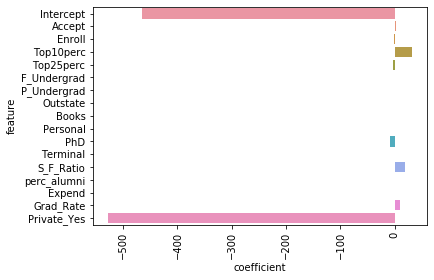

        feature  coefficient
0     Intercept  -465.391213
1        Accept     1.754017
2        Enroll    -1.276501
3     Top10perc    31.935897
4     Top25perc    -3.368276
5   F_Undergrad     0.027038
6   P_Undergrad     0.035687
7      Outstate    -0.057242
8         Books     0.252336
9      Personal     0.059040
10          PhD    -9.213402
11     Terminal     0.000000
12    S_F_Ratio    19.621335
13  perc_alumni     0.000000
14       Expend     0.065520
15    Grad_Rate     8.748270
16  Private_Yes  -528.089563


In [232]:
def lasso_test(lamb):
    model = linear_model.Lasso(alpha = lamb, copy_X = True, fit_intercept = True, max_iter = 10000,
                                  normalize = True, positive = False, precompute = False).fit(x_train,
                                                                                             y_train)
    y_hat = model.predict(x_test)
    print(np.sqrt(mse(y_hat, y_test)))
    df = pd.DataFrame({"feature": "Intercept", "coefficient" : [model.intercept_]})
    lasso_df = df.append(pd.DataFrame({"feature": x_train.columns, "coefficient" : model.coef_}), 
                         ignore_index = True)
    ax = sns.barplot(x = "coefficient", y = "feature", data = lasso_df)
    plt.xticks(rotation = 90)
    plt.show()
    print(lasso_df)
lasso_test(opt_lamb[1])

## Results so far
1. Ridge : 1338.6129252916091
2. Lasso : 1339.7699950677918
3. OLS    : 1340.2003858213411

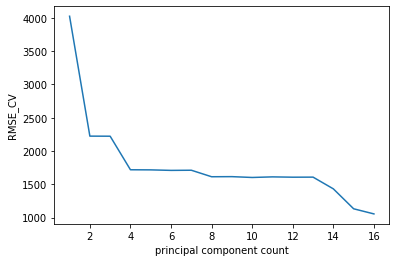

    principal component count      RMSE_CV    RMSE_test
15                         16  1054.766844  3231.443963


/Users/aviralsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [260]:
#time to play with dimensionality reduction a little bit
def pcr_cv(seed, cv_folds):
    #already have defined x & y in code above
    x_ = x_train
    y_ = y_train
    pca = PCA()
    x_reduced = pca.fit_transform(scale(x_))
    M = x_reduced.shape[1]
    MSE = []
    for m in range(M):
        model = LinearRegression()
        cv = KFold(n_splits = cv_folds, random_state = seed, shuffle = True)
        cv10 = cross_val_score(model, x_reduced[:, 0:m+1], y_, cv = cv, 
                               scoring = "neg_mean_squared_error")
        MSE.append(np.mean(np.abs(cv10)))
    df = pd.DataFrame({"principal component count": np.arange(1, M+1), "RMSE_CV" : np.sqrt(MSE)})
    ax = sns.lineplot( x = "principal component count",  y = "RMSE_CV", data = df)
    plt.show()
    
    #time to get the optimal number of principl components
    m = df[df["RMSE_CV"] == df["RMSE_CV"].min()]["principal component count"].iloc[0]
    model = LinearRegression()
    model.fit(x_reduced[:, 0:m+1], y_train)
    y_hat = model.predict(pca.fit_transform(scale(x_test))[:, 0:m+1])
    best_df = df[df["RMSE_CV"] == df["RMSE_CV"].min()]
    best_df["RMSE_test"] = np.sqrt(mse(y_hat, y_test))
    print(best_df)
pcr_cv(10,10)

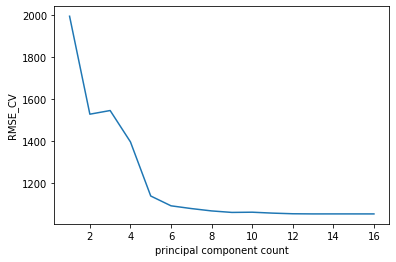

    principal component count      RMSE_CV    RMSE_test
15                         16  1054.766844  1340.200386


/Users/aviralsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [265]:
#time for pls
def pls_cv(seed, cv_folds):
    M = x_train.shape[1]
    MSE = []
    for m in range(M):
        cv = KFold(n_splits=cv_folds, random_state=seed, shuffle = True)
        results = cross_val_score(PLSRegression(n_components = m+1, scale = True,
                                                max_iter = 10000), x_train, y_train, cv = cv,
                                 scoring = "neg_mean_squared_error")
        MSE.append(np.mean(np.abs(results)))
    df = pd.DataFrame({"principal component count": np.arange(1, M+1), "RMSE_CV" : np.sqrt(MSE)})
    ax = sns.lineplot( x = "principal component count",  y = "RMSE_CV", data = df)
    plt.show()
    #time to get the optimal number of principl components
    m = df[df["RMSE_CV"] == df["RMSE_CV"].min()]["principal component count"].iloc[0]
    model = PLSRegression(n_components = m, scale = True,max_iter = 10000).fit(x_train, y_train)
    y_hat = model.predict(x_test)
    best_df = df[df["RMSE_CV"] == df["RMSE_CV"].min()]
    best_df["RMSE_test"] = np.sqrt(mse(y_hat.T[0], y_test))
    print(best_df)
pls_cv(10, 10)